<a href="https://colab.research.google.com/github/avbarbaros/quasi-newton-methods/blob/main/bfgs_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quasi-Newton Methods: BFGS Implementation and Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Callable, Tuple, List, Dict
import time

# =============================================================================
# 1. BFGS IMPLEMENTATION FROM SCRATCH
# =============================================================================

class BFGS:
    """
    Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm implementation.

    This is a quasi-Newton method that approximates the inverse Hessian matrix
    and uses it to find the minimum of a function.
    """

    def __init__(self, f: Callable, grad_f: Callable, x0: np.ndarray,
                 tol: float = 1e-6, max_iter: int = 1000,
                 line_search: str = 'backtracking'):
        """
        Initialize BFGS optimizer.

        Parameters:
        -----------
        f : callable
            Objective function to minimize
        grad_f : callable
            Gradient of the objective function
        x0 : np.ndarray
            Initial point
        tol : float
            Convergence tolerance
        max_iter : int
            Maximum number of iterations
        line_search : str
            Line search method ('backtracking' or 'wolfe')
        """
        self.f = f
        self.grad_f = grad_f
        self.x0 = x0.copy()
        self.tol = tol
        self.max_iter = max_iter
        self.line_search_method = line_search

        # Storage for convergence analysis
        self.x_history = []
        self.f_history = []
        self.grad_norm_history = []
        self.iteration_count = 0

    def backtracking_line_search(self, x: np.ndarray, p: np.ndarray,
                                  grad: np.ndarray, alpha: float = 1.0,
                                  rho: float = 0.5, c: float = 1e-4) -> float:
        """
        Backtracking line search with Armijo condition.

        Parameters:
        -----------
        x : np.ndarray
            Current point
        p : np.ndarray
            Search direction
        grad : np.ndarray
            Gradient at current point
        alpha : float
            Initial step size
        rho : float
            Reduction factor
        c : float
            Armijo constant

        Returns:
        --------
        alpha : float
            Step size satisfying Armijo condition
        """
        fx = self.f(x)

        while self.f(x + alpha * p) > fx + c * alpha * np.dot(grad, p):
            alpha *= rho
            if alpha < 1e-10:  # Prevent too small step sizes
                break

        return alpha

    def wolfe_line_search(self, x: np.ndarray, p: np.ndarray,
                          grad: np.ndarray, alpha: float = 1.0,
                          c1: float = 1e-4, c2: float = 0.9,
                          max_iter: int = 20) -> float:
        """
        Wolfe line search conditions (strong Wolfe conditions).

        Parameters:
        -----------
        x : np.ndarray
            Current point
        p : np.ndarray
            Search direction
        grad : np.ndarray
            Gradient at current point
        alpha : float
            Initial step size
        c1 : float
            Armijo constant
        c2 : float
            Curvature constant
        max_iter : int
            Maximum iterations for line search

        Returns:
        --------
        alpha : float
            Step size satisfying Wolfe conditions
        """
        fx = self.f(x)
        grad_p = np.dot(grad, p)

        # Simple implementation - in practice, use more sophisticated methods
        for _ in range(max_iter):
            x_new = x + alpha * p
            fx_new = self.f(x_new)

            # Check Armijo condition
            if fx_new > fx + c1 * alpha * grad_p:
                alpha *= 0.5
                continue

            # Check curvature condition
            grad_new = self.grad_f(x_new)
            if abs(np.dot(grad_new, p)) > c2 * abs(grad_p):
                alpha *= 0.5
                continue

            break

        return alpha

    def optimize(self) -> Tuple[np.ndarray, Dict]:
        """
        Run BFGS optimization algorithm.

        Returns:
        --------
        x : np.ndarray
            Optimal point found
        info : dict
            Dictionary containing optimization information
        """
        n = len(self.x0)
        x = self.x0.copy()

        # Initialize inverse Hessian approximation as identity matrix
        H = np.eye(n)

        # Compute initial gradient
        grad = self.grad_f(x)

        # Store initial values
        self.x_history.append(x.copy())
        self.f_history.append(self.f(x))
        self.grad_norm_history.append(np.linalg.norm(grad))

        for k in range(self.max_iter):
            self.iteration_count = k + 1

            # Check convergence
            if np.linalg.norm(grad) < self.tol:
                break

            # Compute search direction
            p = -H @ grad

            # Line search
            if self.line_search_method == 'backtracking':
                alpha = self.backtracking_line_search(x, p, grad)
            else:
                alpha = self.wolfe_line_search(x, p, grad)

            # Update position
            x_new = x + alpha * p

            # Compute new gradient
            grad_new = self.grad_f(x_new)

            # BFGS update
            s = x_new - x  # Step
            y = grad_new - grad  # Gradient difference

            # Check curvature condition
            sy = np.dot(s, y)
            if sy > 1e-10:  # Ensure positive curvature
                # Sherman-Morrison formula for inverse Hessian update
                rho = 1.0 / sy
                I = np.eye(n)

                # BFGS update formula
                H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + \
                    rho * np.outer(s, s)

            # Update for next iteration
            x = x_new
            grad = grad_new

            # Store history
            self.x_history.append(x.copy())
            self.f_history.append(self.f(x))
            self.grad_norm_history.append(np.linalg.norm(grad))

        info = {
            'iterations': self.iteration_count,
            'final_gradient_norm': np.linalg.norm(grad),
            'converged': np.linalg.norm(grad) < self.tol,
            'x_history': np.array(self.x_history),
            'f_history': np.array(self.f_history),
            'grad_norm_history': np.array(self.grad_norm_history)
        }

        return x, info

# STANDARD TEST FUNCTIONS

In [2]:
class TestFunctions:
    """Collection of standard test functions for optimization."""

    @staticmethod
    def rosenbrock(x: np.ndarray, a: float = 1.0, b: float = 100.0) -> float:
        """
        Rosenbrock function (banana function).
        Global minimum: f(a, a^2) = 0
        """
        return (a - x[0])**2 + b * (x[1] - x[0]**2)**2

    @staticmethod
    def rosenbrock_grad(x: np.ndarray, a: float = 1.0, b: float = 100.0) -> np.ndarray:
        """Gradient of Rosenbrock function."""
        grad = np.zeros_like(x)
        grad[0] = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)
        grad[1] = 2 * b * (x[1] - x[0]**2)
        return grad

    @staticmethod
    def quadratic(x: np.ndarray) -> float:
        """
        Simple quadratic function.
        Global minimum: f(0, 0) = 0
        """
        return x[0]**2 + x[1]**2

    @staticmethod
    def quadratic_grad(x: np.ndarray) -> np.ndarray:
        """Gradient of quadratic function."""
        return 2 * x

    @staticmethod
    def beale(x: np.ndarray) -> float:
        """
        Beale function.
        Global minimum: f(3, 0.5) = 0
        """
        return (1.5 - x[0] + x[0]*x[1])**2 + \
               (2.25 - x[0] + x[0]*x[1]**2)**2 + \
               (2.625 - x[0] + x[0]*x[1]**3)**2

    @staticmethod
    def beale_grad(x: np.ndarray) -> np.ndarray:
        """Gradient of Beale function."""
        grad = np.zeros(2)

        t1 = 1.5 - x[0] + x[0]*x[1]
        t2 = 2.25 - x[0] + x[0]*x[1]**2
        t3 = 2.625 - x[0] + x[0]*x[1]**3

        grad[0] = 2*t1*(-1 + x[1]) + 2*t2*(-1 + x[1]**2) + 2*t3*(-1 + x[1]**3)
        grad[1] = 2*t1*x[0] + 2*t2*x[0]*2*x[1] + 2*t3*x[0]*3*x[1]**2

        return grad

    @staticmethod
    def himmelblau(x: np.ndarray) -> float:
        """
        Himmelblau's function.
        Has 4 local minima, all with value 0
        """
        return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

    @staticmethod
    def himmelblau_grad(x: np.ndarray) -> np.ndarray:
        """Gradient of Himmelblau's function."""
        grad = np.zeros(2)
        grad[0] = 4*x[0]*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)
        grad[1] = 2*(x[0]**2 + x[1] - 11) + 4*x[1]*(x[0] + x[1]**2 - 7)
        return grad

    @staticmethod
    def booth(x: np.ndarray) -> float:
        """
        Booth function.
        Global minimum: f(1, 3) = 0
        """
        return (x[0] + 2*x[1] - 7)**2 + (2*x[0] + x[1] - 5)**2

    @staticmethod
    def booth_grad(x: np.ndarray) -> np.ndarray:
        """Gradient of Booth function."""
        grad = np.zeros(2)
        grad[0] = 2*(x[0] + 2*x[1] - 7) + 4*(2*x[0] + x[1] - 5)
        grad[1] = 4*(x[0] + 2*x[1] - 7) + 2*(2*x[0] + x[1] - 5)
        return grad

#COMPARISON WITH SCIPY'S IMPLEMENTATION

In [3]:
def compare_implementations(test_functions: List[Dict], initial_points: List[np.ndarray]) -> Dict:
    """
    Compare custom BFGS implementation with SciPy's implementation.

    Parameters:
    -----------
    test_functions : list
        List of dictionaries containing function info
    initial_points : list
        List of initial points to test

    Returns:
    --------
    results : dict
        Dictionary containing comparison results
    """
    results = {}

    for func_info in test_functions:
        func_name = func_info['name']
        f = func_info['function']
        grad_f = func_info['gradient']
        true_min = func_info.get('minimum', None)

        results[func_name] = {}

        for i, x0 in enumerate(initial_points):
            print(f"\nTesting {func_name} with initial point {i+1}: {x0}")

            # Custom BFGS
            start_time = time.time()
            bfgs = BFGS(f, grad_f, x0, tol=1e-6, max_iter=1000)
            x_custom, info_custom = bfgs.optimize()
            time_custom = time.time() - start_time

            # SciPy BFGS
            start_time = time.time()
            result_scipy = minimize(f, x0, method='BFGS', jac=grad_f,
                                   options={'gtol': 1e-6, 'maxiter': 1000})
            time_scipy = time.time() - start_time

            # Store results
            results[func_name][f'point_{i+1}'] = {
                'initial_point': x0,
                'custom': {
                    'x': x_custom,
                    'f': f(x_custom),
                    'iterations': info_custom['iterations'],
                    'converged': info_custom['converged'],
                    'time': time_custom,
                    'history': info_custom
                },
                'scipy': {
                    'x': result_scipy.x,
                    'f': result_scipy.fun,
                    'iterations': result_scipy.nit,
                    'converged': result_scipy.success,
                    'time': time_scipy
                }
            }

            # Calculate error if true minimum is known
            if true_min is not None:
                results[func_name][f'point_{i+1}']['custom']['error'] = \
                    np.linalg.norm(x_custom - true_min)
                results[func_name][f'point_{i+1}']['scipy']['error'] = \
                    np.linalg.norm(result_scipy.x - true_min)

    return results

#CONVERGENCE RATE ANALYSIS

In [4]:
def analyze_convergence_rate(history: Dict, true_min: np.ndarray = None) -> Dict:
    """
    Analyze the convergence rate of the optimization.

    Parameters:
    -----------
    history : dict
        History dictionary from BFGS optimization
    true_min : np.ndarray, optional
        True minimum point (if known)

    Returns:
    --------
    analysis : dict
        Dictionary containing convergence analysis
    """
    x_history = history['x_history']
    f_history = history['f_history']
    grad_norm_history = history['grad_norm_history']

    n_iter = len(f_history)

    # Function value convergence
    f_improvements = np.abs(np.diff(f_history))

    # Gradient norm decay
    grad_ratios = grad_norm_history[1:] / (grad_norm_history[:-1] + 1e-15)

    # Distance to optimum (if known)
    if true_min is not None:
        distances = np.linalg.norm(x_history - true_min, axis=1)
        distance_ratios = distances[1:] / (distances[:-1] + 1e-15)
    else:
        distances = None
        distance_ratios = None

    # Estimate convergence rate
    # Linear convergence: ||x_{k+1} - x*|| ≈ c * ||x_k - x*||
    # Superlinear: ratio goes to 0
    # Quadratic: ||x_{k+1} - x*|| ≈ c * ||x_k - x*||^2

    analysis = {
        'iterations': n_iter,
        'final_f': f_history[-1],
        'final_grad_norm': grad_norm_history[-1],
        'f_improvements': f_improvements,
        'grad_ratios': grad_ratios,
        'distances': distances,
        'distance_ratios': distance_ratios,
        'average_grad_ratio': np.mean(grad_ratios[-10:]) if len(grad_ratios) > 10 else np.mean(grad_ratios)
    }

    return analysis

#VISUALIZATION

In [5]:
def plot_convergence(results: Dict, test_function_name: str, save_path: str = None):
    """
    Create comprehensive convergence plots.

    Parameters:
    -----------
    results : dict
        Results dictionary from comparison
    test_function_name : str
        Name of the test function
    save_path : str, optional
        Path to save the figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'BFGS Convergence Analysis: {test_function_name}', fontsize=14, fontweight='bold')

    # Get results for first initial point
    point_key = list(results[test_function_name].keys())[0]
    custom_history = results[test_function_name][point_key]['custom']['history']

    iterations = range(len(custom_history['f_history']))

    # Plot 1: Function value
    axes[0, 0].semilogy(iterations, custom_history['f_history'], 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Iteration', fontsize=11)
    axes[0, 0].set_ylabel('Function Value', fontsize=11)
    axes[0, 0].set_title('Function Value Convergence', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Gradient norm
    axes[0, 1].semilogy(iterations, custom_history['grad_norm_history'], 'r-', linewidth=2)
    axes[0, 1].set_xlabel('Iteration', fontsize=11)
    axes[0, 1].set_ylabel('Gradient Norm', fontsize=11)
    axes[0, 1].set_title('Gradient Norm Convergence', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Function improvement
    if len(custom_history['f_history']) > 1:
        f_improvements = np.abs(np.diff(custom_history['f_history']))
        axes[1, 0].semilogy(range(len(f_improvements)), f_improvements, 'g-', linewidth=2)
        axes[1, 0].set_xlabel('Iteration', fontsize=11)
        axes[1, 0].set_ylabel('|f(x_{k+1}) - f(x_k)|', fontsize=11)
        axes[1, 0].set_title('Function Improvement per Iteration', fontsize=12)
        axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Optimization trajectory (for 2D problems)
    if custom_history['x_history'].shape[1] == 2:
        x_traj = custom_history['x_history']
        axes[1, 1].plot(x_traj[:, 0], x_traj[:, 1], 'bo-', linewidth=1.5, markersize=4)
        axes[1, 1].plot(x_traj[0, 0], x_traj[0, 1], 'go', markersize=10, label='Start')
        axes[1, 1].plot(x_traj[-1, 0], x_traj[-1, 1], 'r*', markersize=15, label='End')
        axes[1, 1].set_xlabel('x₁', fontsize=11)
        axes[1, 1].set_ylabel('x₂', fontsize=11)
        axes[1, 1].set_title('Optimization Trajectory', fontsize=12)
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def plot_comparison_summary(results: Dict, save_path: str = None):
    """
    Create summary comparison plots between custom and SciPy implementations.

    Parameters:
    -----------
    results : dict
        Results dictionary from comparison
    save_path : str, optional
        Path to save the figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('BFGS Implementation Comparison: Custom vs SciPy', fontsize=14, fontweight='bold')

    function_names = []
    custom_iters = []
    scipy_iters = []
    custom_times = []
    scipy_times = []

    for func_name, func_results in results.items():
        for point_key, point_results in func_results.items():
            function_names.append(f"{func_name}\n{point_key}")
            custom_iters.append(point_results['custom']['iterations'])
            scipy_iters.append(point_results['scipy']['iterations'])
            custom_times.append(point_results['custom']['time'] * 1000)  # Convert to ms
            scipy_times.append(point_results['scipy']['time'] * 1000)

    x = np.arange(len(function_names))
    width = 0.35

    # Plot 1: Iterations comparison
    axes[0].bar(x - width/2, custom_iters, width, label='Custom BFGS', alpha=0.8)
    axes[0].bar(x + width/2, scipy_iters, width, label='SciPy BFGS', alpha=0.8)
    axes[0].set_xlabel('Test Case', fontsize=11)
    axes[0].set_ylabel('Number of Iterations', fontsize=11)
    axes[0].set_title('Iteration Count Comparison', fontsize=12)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(function_names, rotation=45, ha='right', fontsize=9)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Plot 2: Time comparison
    axes[1].bar(x - width/2, custom_times, width, label='Custom BFGS', alpha=0.8)
    axes[1].bar(x + width/2, scipy_times, width, label='SciPy BFGS', alpha=0.8)
    axes[1].set_xlabel('Test Case', fontsize=11)
    axes[1].set_ylabel('Execution Time (ms)', fontsize=11)
    axes[1].set_title('Execution Time Comparison', fontsize=12)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(function_names, rotation=45, ha='right', fontsize=9)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

def plot_contour_with_trajectory(f: Callable, x_history: np.ndarray,
                                 bounds: Tuple[float, float] = (-5, 5),
                                 title: str = "Optimization Trajectory",
                                 save_path: str = None):
    """
    Plot contour of function with optimization trajectory.

    Parameters:
    -----------
    f : callable
        Function to plot
    x_history : np.ndarray
        History of x values during optimization
    bounds : tuple
        Plot bounds (min, max)
    title : str
        Plot title
    save_path : str, optional
        Path to save the figure
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create grid
    x1 = np.linspace(bounds[0], bounds[1], 200)
    x2 = np.linspace(bounds[0], bounds[1], 200)
    X1, X2 = np.meshgrid(x1, x2)

    # Evaluate function
    Z = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i, j] = f(np.array([X1[i, j], X2[i, j]]))

    # Plot contour
    levels = np.logspace(-1, 3, 20)
    contour = ax.contour(X1, X2, Z, levels=levels, cmap='viridis', alpha=0.6)
    ax.clabel(contour, inline=True, fontsize=8)

    # Plot trajectory
    ax.plot(x_history[:, 0], x_history[:, 1], 'r.-', linewidth=2,
            markersize=8, label='BFGS Trajectory')
    ax.plot(x_history[0, 0], x_history[0, 1], 'go', markersize=12,
            label='Start', zorder=5)
    ax.plot(x_history[-1, 0], x_history[-1, 1], 'r*', markersize=18,
            label='End', zorder=5)

    ax.set_xlabel('x₁', fontsize=12)
    ax.set_ylabel('x₂', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

BFGS QUASI-NEWTON METHOD: COMPREHENSIVE ANALYSIS

COMPARING CUSTOM BFGS WITH SCIPY IMPLEMENTATION

Testing Rosenbrock with initial point 1: [-1.2  1. ]

Testing Rosenbrock with initial point 2: [0. 0.]

Testing Rosenbrock with initial point 3: [2. 2.]

Testing Quadratic with initial point 1: [-1.2  1. ]

Testing Quadratic with initial point 2: [0. 0.]

Testing Quadratic with initial point 3: [2. 2.]

Testing Beale with initial point 1: [-1.2  1. ]

Testing Beale with initial point 2: [0. 0.]

Testing Beale with initial point 3: [2. 2.]

Testing Booth with initial point 1: [-1.2  1. ]

Testing Booth with initial point 2: [0. 0.]

Testing Booth with initial point 3: [2. 2.]

DETAILED RESULTS

Rosenbrock Function:
------------------------------------------------------------

  point_1: x0 = [-1.2  1. ]
    Custom BFGS:
      Final x: [1.         0.99999999]
      Final f(x): 2.745638e-17
      Iterations: 35
      Time: 9.13 ms
      Error: 1.086480e-08
    SciPy BFGS:
      Final x: [1. 

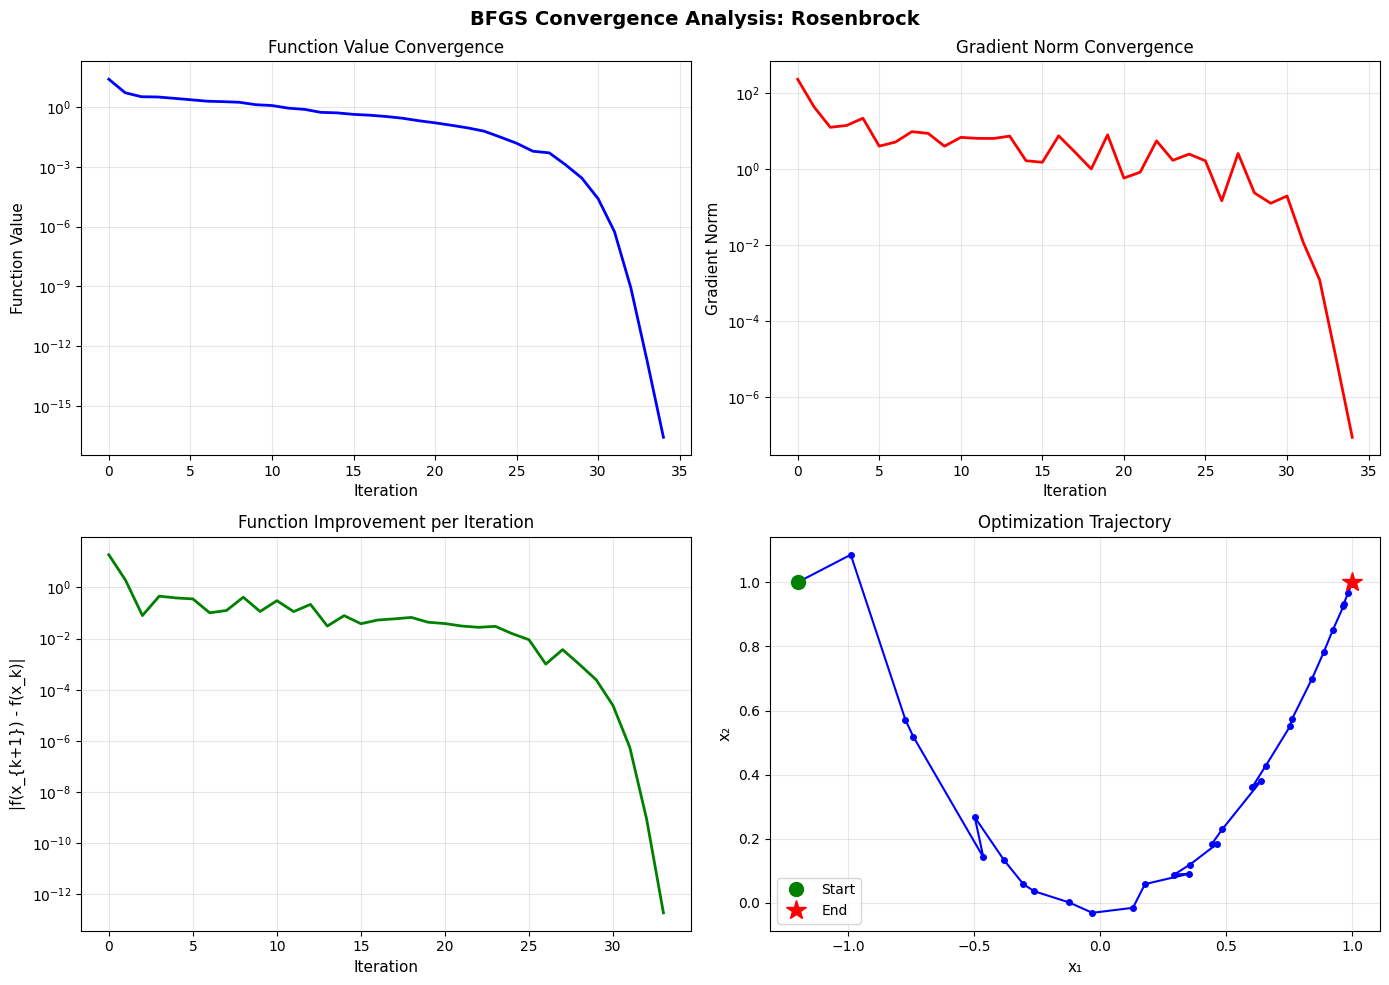

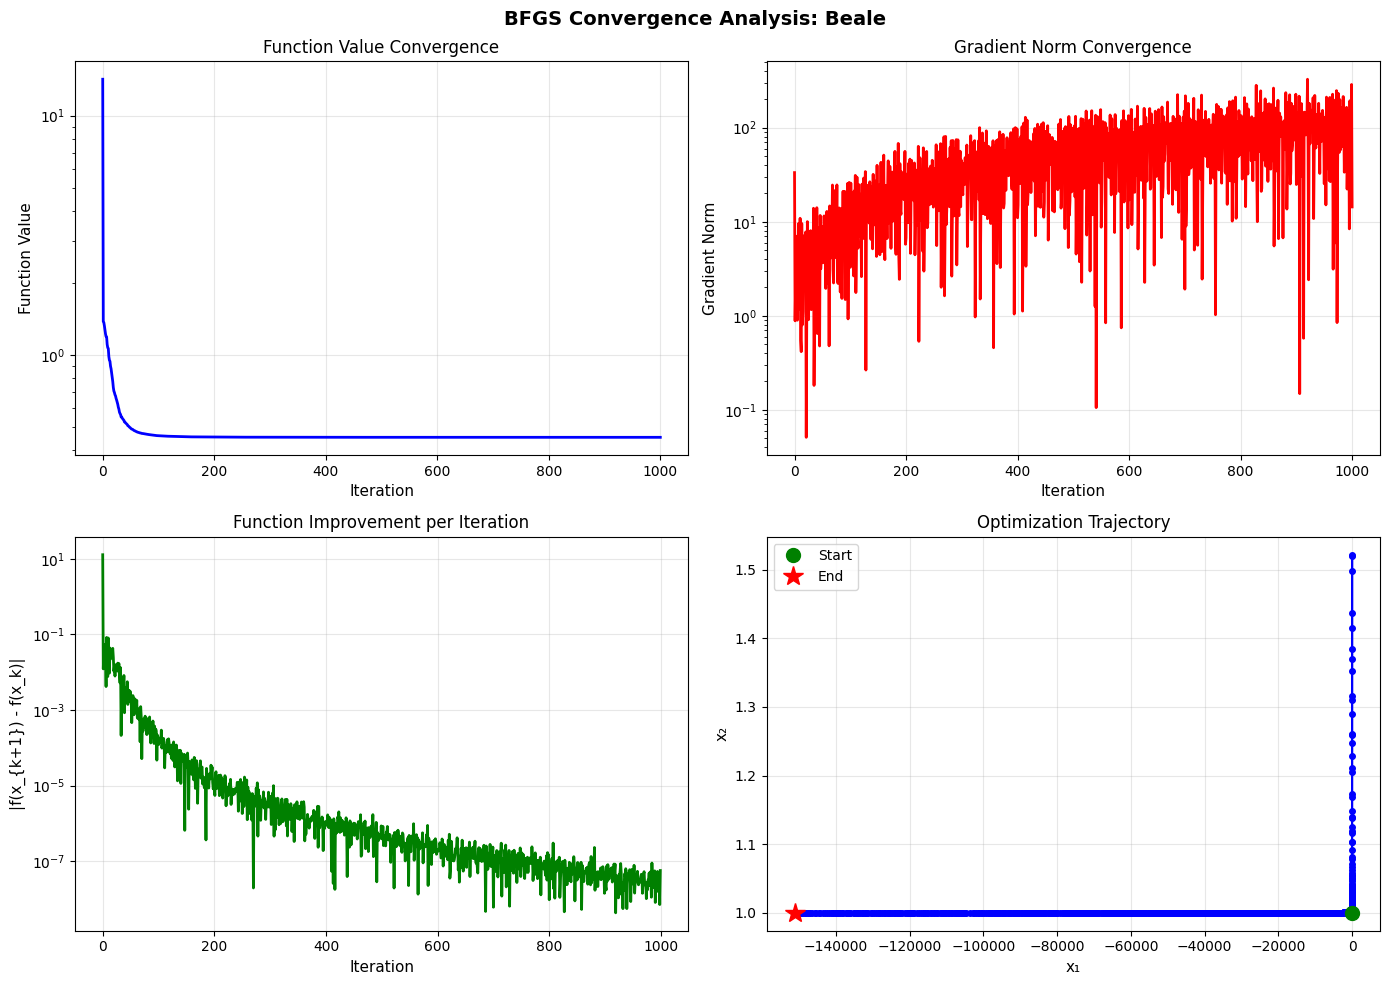

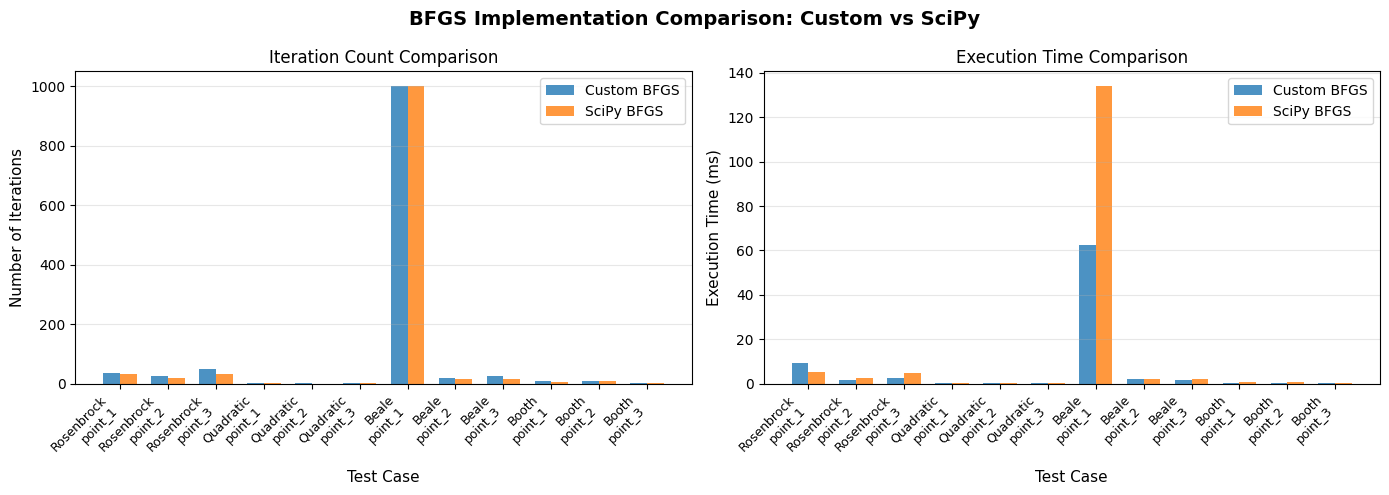

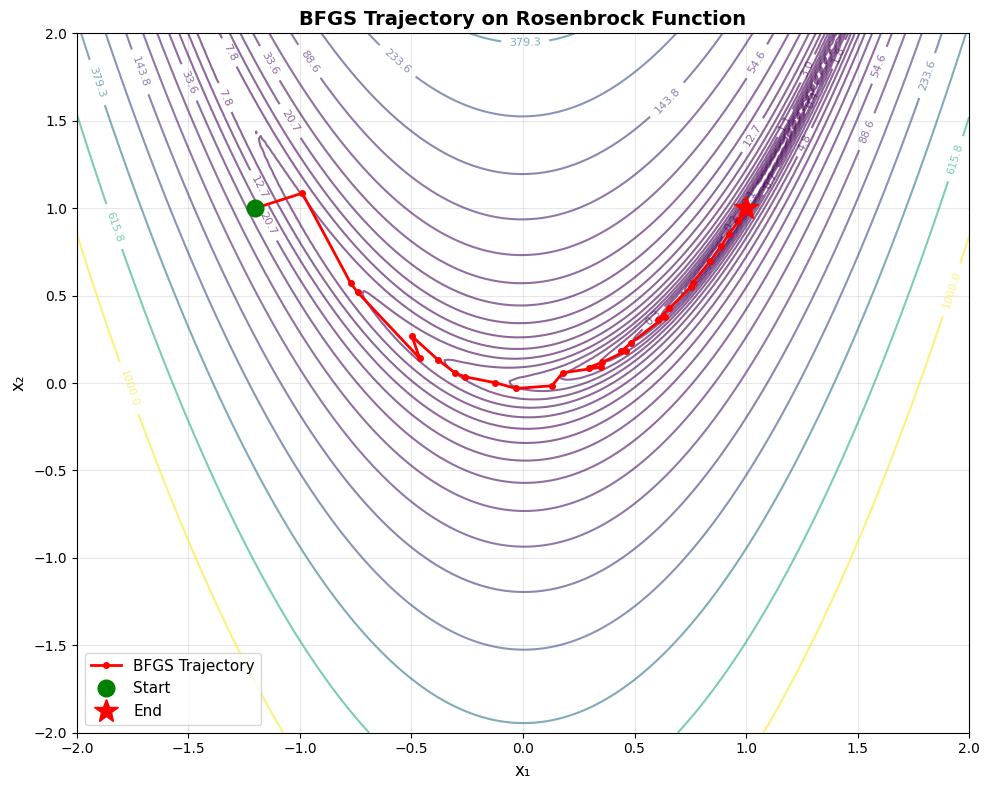

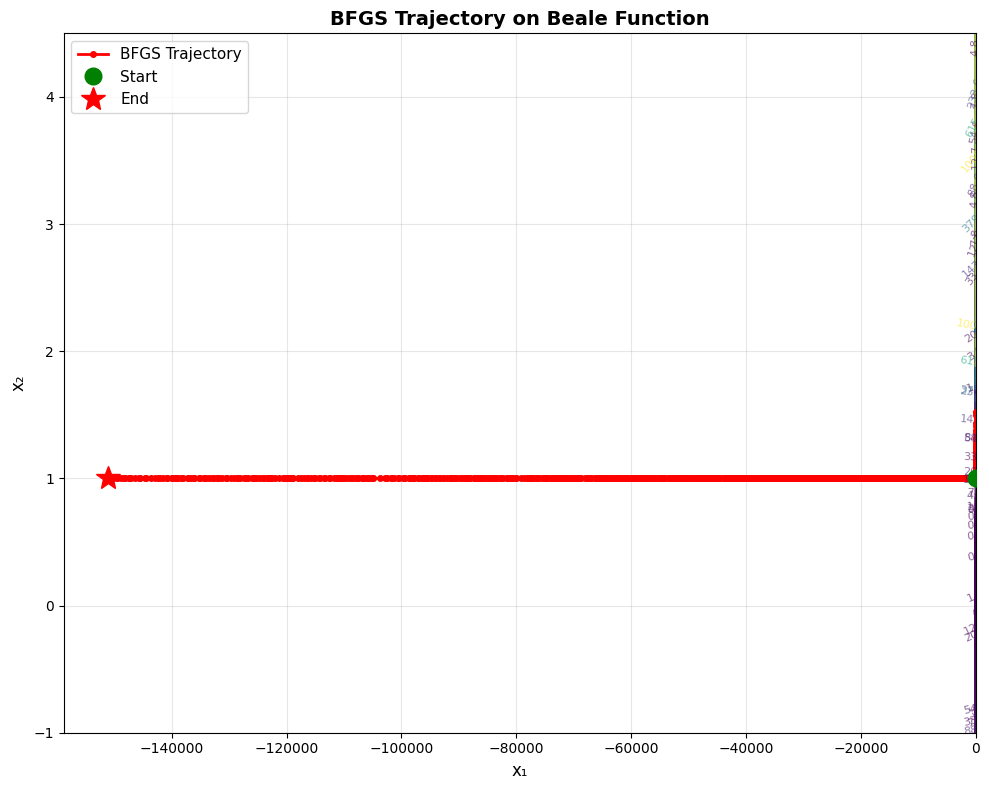


Analysis complete! All plots have been saved.

You can now perform additional analysis using the 'results' dictionary.
Available test functions: Rosenbrock, Quadratic, Beale, Booth

Example: Access Rosenbrock results with results['Rosenbrock']


In [6]:
# =============================================================================
# 6. MAIN EXECUTION AND REPORTING
# =============================================================================

def run_complete_analysis():
    """Run complete BFGS analysis and generate report."""

    print("="*80)
    print("BFGS QUASI-NEWTON METHOD: COMPREHENSIVE ANALYSIS")
    print("="*80)

    # Define test functions
    test_functions = [
        {
            'name': 'Rosenbrock',
            'function': TestFunctions.rosenbrock,
            'gradient': TestFunctions.rosenbrock_grad,
            'minimum': np.array([1.0, 1.0])
        },
        {
            'name': 'Quadratic',
            'function': TestFunctions.quadratic,
            'gradient': TestFunctions.quadratic_grad,
            'minimum': np.array([0.0, 0.0])
        },
        {
            'name': 'Beale',
            'function': TestFunctions.beale,
            'gradient': TestFunctions.beale_grad,
            'minimum': np.array([3.0, 0.5])
        },
        {
            'name': 'Booth',
            'function': TestFunctions.booth,
            'gradient': TestFunctions.booth_grad,
            'minimum': np.array([1.0, 3.0])
        }
    ]

    # Define initial points for testing
    initial_points = [
        np.array([-1.2, 1.0]),
        np.array([0.0, 0.0]),
        np.array([2.0, 2.0])
    ]

    # Run comparison
    print("\n" + "="*80)
    print("COMPARING CUSTOM BFGS WITH SCIPY IMPLEMENTATION")
    print("="*80)
    results = compare_implementations(test_functions, initial_points)

    # Print detailed results
    print("\n" + "="*80)
    print("DETAILED RESULTS")
    print("="*80)
    for func_name, func_results in results.items():
        print(f"\n{func_name} Function:")
        print("-" * 60)
        for point_key, point_results in func_results.items():
            print(f"\n  {point_key}: x0 = {point_results['initial_point']}")
            print(f"    Custom BFGS:")
            print(f"      Final x: {point_results['custom']['x']}")
            print(f"      Final f(x): {point_results['custom']['f']:.6e}")
            print(f"      Iterations: {point_results['custom']['iterations']}")
            print(f"      Time: {point_results['custom']['time']*1000:.2f} ms")
            if 'error' in point_results['custom']:
                print(f"      Error: {point_results['custom']['error']:.6e}")

            print(f"    SciPy BFGS:")
            print(f"      Final x: {point_results['scipy']['x']}")
            print(f"      Final f(x): {point_results['scipy']['f']:.6e}")
            print(f"      Iterations: {point_results['scipy']['iterations']}")
            print(f"      Time: {point_results['scipy']['time']*1000:.2f} ms")
            if 'error' in point_results['scipy']:
                print(f"      Error: {point_results['scipy']['error']:.6e}")

    # Analyze convergence rate for Rosenbrock function
    print("\n" + "="*80)
    print("CONVERGENCE RATE ANALYSIS (Rosenbrock Function)")
    print("="*80)
    rosenbrock_results = results['Rosenbrock']['point_1']
    convergence_analysis = analyze_convergence_rate(
        rosenbrock_results['custom']['history'],
        np.array([1.0, 1.0])
    )
    print(f"Total iterations: {convergence_analysis['iterations']}")
    print(f"Final function value: {convergence_analysis['final_f']:.6e}")
    print(f"Final gradient norm: {convergence_analysis['final_grad_norm']:.6e}")
    print(f"Average gradient ratio (last 10 iter): {convergence_analysis['average_grad_ratio']:.6f}")

    # Create visualizations
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    # Convergence plots
    plot_convergence(results, 'Rosenbrock', save_path='rosenbrock_convergence.png')
    plot_convergence(results, 'Beale', save_path='beale_convergence.png')

    # Comparison summary
    plot_comparison_summary(results, save_path='implementation_comparison.png')

    # Contour plots with trajectories
    rosenbrock_history = results['Rosenbrock']['point_1']['custom']['history']['x_history']
    plot_contour_with_trajectory(
        TestFunctions.rosenbrock,
        rosenbrock_history,
        bounds=(-2, 2),
        title="BFGS Trajectory on Rosenbrock Function",
        save_path='rosenbrock_trajectory.png'
    )

    beale_history = results['Beale']['point_1']['custom']['history']['x_history']
    plot_contour_with_trajectory(
        TestFunctions.beale,
        beale_history,
        bounds=(-1, 4.5),
        title="BFGS Trajectory on Beale Function",
        save_path='beale_trajectory.png'
    )

    print("\nAnalysis complete! All plots have been saved.")
    print("="*80)

    return results

# =============================================================================
# EXECUTE ANALYSIS
# =============================================================================

if __name__ == "__main__":
    # Run the complete analysis
    results = run_complete_analysis()